# VASIM Autoscaling Simulator Toolkit Example

### Goals

1. **Applicability:** Integration with various algorithms and parameter customization.

2. **Simulation:** Realistic workload modeling, achieved within minutes.

3. **Parameter Tuning:** Fine-tuning for optimal performance and cost savings.

4. **Cost Analysis:** Demonstrating potential cost savings.


### Overview: Autoscaling Components


<img src="../docs/demo_pics/Autoscaling_infra.png" alt="Autoscaling Components" title="Autoscaling Components" width="300" >

- Application: The running software, such as Postgres and SQL Server.
- Controller: Manages tasks and publishes metrics.
- Metrics Server: Stores and provides metrics.
- Recommender Algorithm: Makes resource allocation decisions.
- Scaler Entity: Enacts decisions, adjusting resource allocation.

These components work together for effective autoscaling.


### Components

VASIM is a standalone Python package that internally replicates these components, maintaining and processing scaling states. It also includes a cluster state simulator for current utilization and limits, along with a post-processing analyzer for performance assessment. Input is in the same format as timestamp and utilization datasets. Output is a set of metrics and scaling decision trace.

VASIM allows you to try different recommender algorithms to adapt to different workloads. Workloads can be bursty, monotononic, cyclical, and business needs may vary based on complexity, cost, and performance.

<img src="../docs/demo_pics/VASim_infra.png" alt="VASIM Overview" title="VASIM Overview" width="300">




# Getting started

First, clone the code. You'll be modifying some of the python files, so make sure to add the `-e` to make it editable.  If you have not done this yet, uncomment the block below and run it.  (We leave it as commented out for now to avoid accidentally rerunning it!)

In [1]:
# git clone https://github.com/microsoft/vasim.git .
# cd vasim
# python -m pip install -e .[dev]
# cd examples




### Prepare data:
Get your test data. For this experiment we'll be working with the [Alibaba dataset](https://github.com/alibaba/clusterdata), trace c_12104.

There are some important things to note about the data for Vasim.

1. You currently must name your csv's ending with `perf_event_log.csv`. (Ex: `c_12104.csv_perf_event_log.csv`.)  This is so the ingester does not accidentally read in other files in the directory such as output files.
2. You must format your data in two columns (`TIMESTAMP`,`CPU_USAGE_ACTUAL`) as follows:  (TODO: We [plan](https://github.com/microsoft/vasim/issues/34) to use Open Telemetry format in the future.) 
3. You may have multiple CSVs, just put everything in the same folder.

In [2]:
! head data/c_12104.csv_perf_event_log.csv

TIMESTAMP,CPU_USAGE_ACTUAL
2023.04.02-00:09:00:000,7.2
2023.04.02-00:10:00:000,7.04
2023.04.02-00:11:00:000,6.88
2023.04.02-00:12:00:000,6.72
2023.04.02-00:13:00:000,6.48
2023.04.02-00:14:00:000,6.501818181818182
2023.04.02-00:15:00:000,6.523636363636364
2023.04.02-00:16:00:000,6.545454545454546
2023.04.02-00:17:00:000,6.567272727272727


### Prepare algorithm

You also need to implement your Recommender algorithm. There are examples in the [recommender](../recommender) folder.

To implement a recommender you will need to create a file for your algorithm, add any paramters you need to the `__init__` function and then implement the core logic of your recommender in the `run()` function.

```python
class SimpleAdditiveRecommender(Recommender):
    def __init__(self, cluster_state_provider, save_metadata=True):
        # Copy the code at the top of this function as-is.

        # Put your parameters here hard-coded, or pass them in to your
        # `metadata.json` file in the `algo_specific_config` section.
        self.my_param = self.algo_params.get("myparam", 2)

    def run(self, recorded_data):
        """
        This method runs the recommender algorithm and returns the new number of
              cores to scale to (new limit).

        Inputs:
            recorded_data (pd.DataFrame): The recorded metrics data for the current time window to simulate
        Returns:
            latest_time (datetime): The latest time of the performance data.
            new_limit (float): The new number of cores to scale to.
        """

        # Your logic goes here! Look at the data in the `recorded_data` dataframe,
        #   do a calculation, and return the number of cores to scale to.

        return new_limit
```


For this example, we'll be working with the [DummyAdditiveRecommender](https://github.com/microsoft/vasim/blob/main/src/vasim/recommender/DummyAdditiveRecommender.py), which takes a moving average of the CPU values and adds a fixed buffer amount to the top.

We'll define a parameter: `"addend": 2`, and this will add `2` CPU cores to the limit, providing a healthy buffer.

### Preparing metadata.json
We also need to prepare a file that provides the default set of configuration parameters. You can see some examples of this file in [the test folder](../tests/test_data/alibaba_control_c_29247_denom_1_mini). The default name of this file is `metadata.json`, but you can give it any name and pass it in as a parameter.

There are three sets of parameters:
* **`algo_specific_config`** : this is where you put the parameters you will use in your algorithm's `run` function
  * An example: `addend: 2` for the `DummyAdditiveRecommender` we'll be using for this example.
* **`general_config`** : These are the parameters related to how the csv trace data is passed in, and the simulation safe-guards.
  * `window` (int): the amount of data that is passed to the algorithm in the `recorded_data` paramaeter in the `run` function. _See "original window" below_
  * `lag` (float): Number of minutes to wait after making a decision
  * `min_cpu_limit` (int): The minimum number of cores to recommend. This is used as a [safety guard](https://github.com/microsoft/vasim/blob/198a06062a91f6455b87710b0e59834530b6ea29/simulator/SimulatedInfraScaler.py#L56) in the simulated infra.
  * `max_cpu_limit` (int): The maximum number of cores to recommend. (same as min)
  * `recovery_time` (int of minutes, optional, default is 15): The **minimum** amount of time in minutes to wait before making another scaling decision.
* **`prediction_config`** : this relates to the window of [predicted](https://github.com/microsoft/vasim/blob/198a06062a91f6455b87710b0e59834530b6ea29/recommender/cluster_state_provider/PredictiveFileClusterStateProvider.py#L29) data that is fed into the algorithm. It uses a time series to forecast what the data might be in the future to help the algorithm proactively scale
  * `enabled` (boolean) : This flag controls if prediction is enabled or ignored. If enabled, simulation will use below parameter for time series forecasting to predict future load.  
  * `waiting_before_predict` (int of minutes) : This is the amount of data to consume before making prediction. It is usually set to `1440`, for 60 min * 24 hours = 1 day. In general, it is waiting for one full cycle of data (`period` in the graph below) to pass. Sometimes this is daily, sometimes weekly, etc.  TODO: autodetermine this.
  * `frequency_minutes` (int) : This is how frequent your timestamps are in the csvs you provide. This *MUST* match your csvs.  (Ex: 1 in the above case.) TODO: automate.
  * `forecasting_models` (string, unused): For now we only support "naive".  This parameter is not currently used because it's the only thing supported. However, you still must provide a string for now as a placeholder
  * `minutes_to_predict` (int): This is the “forecasting horizon” below/how much to look forward.  Increasing this means you’ll be MORE proactive in adjusting based on history. This is a good one to tune depending on how consisten your data is.
  * `total_predictive_window` (int): _This is the "new window" in the diagram below_, essentially the total amount of minutes you want in the window. A common setting for this parameter is `minutes_to_predict`/`frequency_minutes` + `window`.  If you would like to change this, you can do it here. 
   

Some important things to note:
* `recovery_time` means that the simulator will NOT scale up/down even if the decision indicates to scale, until that minimum number of minutes has passed. This simulates a live system recovering.
* `lag` is the number of minutes to wait between making a decision/running your `run()` function. For example, for very heavy-weight algorithms, you may only want to run every 10 minutes. This also is used to prevent thrashing.

Here is a picture that explains the `window` and `prediction_config`:

<img src="../docs/demo_pics/predictive_window.png" alt="Data Windows" title="Data Windows" >

Here is an example of the `metadata.json`:

In [3]:
! cat data/metadata.json

{
    "algo_specific_config": {
        "addend": 2
    },
    "general_config": {
        "window": 20,
        "lag": 10,
        "max_cpu_limit": 25,
        "min_cpu_limit": 2.0
    },
    "prediction_config": {
        "enabled": false,
        "waiting_before_predict": 1440,
        "frequency_minutes": 1,
        "minutes_to_predict": 10,
        "forecasting_models": "naive",
        "total_predictive_window": 30
    }
}

Once you have all three (CSV, algo, metadata), for now, there is one last step. (TODO: [Issue #19](https://github.com/microsoft/vasim/issues/19))  You must currently [add the name of your algorithm to the simulator](https://github.com/microsoft/vasim/blob/9b50d9080d4a26fbad014159484fd110af95fa75/simulator/InMemorySimulator.py#L87) for it to be called, and import it at the top of the [InMemorySimulator.py file](../simulator/InMemorySimulator.py).

```python
 def _create_recommender_algorithm(self, algorithm):
        if algorithm == 'multiplicative':
            return SimpleMultiplierRecommender(self.cluster_state_provider)
        elif algorithm == 'additive':
            return SimpleAdditiveRecommender(self.cluster_state_provider)
        # Add your own algorithm here!!!
        # TODO: Make this more dynamic
        else:
            raise ValueError(f"Unknown algorithm: {algorithm}")
```

**REMEMEBER: You must reload this notebook/restart the kernel for Python to see your new algorithm**


## Getting started with a single simulation

Now that we have the csv, algorithm, and parameter config, we can run a single simulation for a fixed set of parameters.

`initial_cpu_limit` is the current limit that your system is set to. (TODO: we could move this to `metadata.json` but we found that value changed more than the other variables in the file, so for now it is a parameter.)


##### Important
If you get an error below that is something like `KeyError: "Cannot get left slice bound for non-unique label: Timestamp...` this is because you have some non perf_event_log.csvs in your "data" folder, most likely output in the `_siulations` output folder. This is a [bug](https://github.com/microsoft/vasim/issues/18).

To prevent this, let's clear out old output files:

In [4]:
# clear out CSV results from prior runs
! rm -rf data/_simulations
! rm -rf data_tuning

In [5]:
from vasim.simulator.InMemorySimulator import InMemoryRunnerSimulator

# Specify your data directory, algorithm, initial cores count and config path if you did not name your metadata.json as metadata.json
runner = InMemoryRunnerSimulator(data_dir="data/",  algorithm="additive", initial_cpu_limit=10, config_path="data/metadata.json")

# disable the infra logger from printing to console
runner.infra_scaler.logger.disabled = True

results = runner.run_simulation()

INFO:vasim.simulator.SimulatedInfraScaler:>>>SimulatedInfraScaler initialized
ERROR:root:Not enough data to make a decision. (May be due to warmup time).


Prediction config was detected:{'enabled': False, 'waiting_before_predict': 1440, 'frequency_minutes': 1, 'minutes_to_predict': 10, 'forecasting_models': 'naive', 'total_predictive_window': 30}
config: {}
logger: <RootLogger root (ERROR)>
data_dir: /home/osdi-eval/vasim/examples/data
features: ['cpu']
decision_file_path: /home/osdi-eval/vasim/examples/data/_simulations/target_cfg-0495552d-84d4/decisions.csv
save_metadata: True
frequency_minutes: 1
minutes_to_predict: 10
freq: 1T
waiting_time: 1440
data_processor: <vasim.recommender.forecasting.utils.helpers.DataProcessor object at 0x7497c2337eb0>
data_forecaster: <vasim.recommender.forecasting.TimeSeriesForecaster.TimeSeriesForecaster object at 0x74983c8d8b20>
cores: 0
predicted_cores: 0
_prediction_activated: False
number_of_points_to_predict: 10
predictive_window: 30
curr_cpu_limit: None
Starting simulation at 2023-04-02 00:09:00 and continuing till 2023-04-09 23:20:00
Setting number of cores to 10
Simulation finished at 2023-04-09 2

You can see in the output above that the metadata.json file is read and the simulation is run. The results are stored in the results variable. You can print the results to see the output.

**NOTE** These results will also be saved in a folder started with `_simulations/target_*` with the `*` being a uniquely generated identifier


In [6]:
# pretty print the results
import json
print(json.dumps(results, indent=2))

{
  "average_slack": 2.6615605822802952,
  "average_insufficient_cpu": 0.011724998250317914,
  "sum_slack": 30477.530227691663,
  "sum_insufficient_cpu": 134.26295496439045,
  "num_scalings": 289,
  "num_insufficient_cpu": 99,
  "insufficient_observations_percentage": 0.8645533141210375,
  "slack_percentage": 23.172159395780824,
  "median_insufficient_cpu": 0.0,
  "median_slack": 2.4399999999999995,
  "max_slack": 8.236
}


### Understanding the output


Of the json output above, the fields are as follows:
* `average_slack` - The average slack in CPU cores across all the time intervals. (Ex: here it is 2.66 because the "additive" algorithm is adding 2 cores for a buffer)
* `average_insufficient_cpu` - The average number of insufficient CPU cores across all the time intervals. (Ex: here it is nearly 0 because the "additive" algorithm is adding 2 cores for a buffer)
* `sum_slack` - The sum of slack in CPU cores across all the time intervals.
* `sum_insufficient_cpu` - The sum of CPU cores that were insufficient across all the time intervals.
* `num_scalings` - The number of times the CPU was scaled by the simulated scaler.
* `num_insufficient_cpu` - The number of times the CPU was insufficient across all the time intervals.
* `insufficient_observations_percentage` - The percentage of times the CPU was insufficient across all the time intervals.
* `slack_percentage` - The percentage of slack in CPU cores across all the time intervals.
* `median_insufficient_cpu` - The median number of insufficient CPU cores across all the time intervals 
* `median_slack` - The median slack in CPU cores across all the time intervals.
* `max_slack` - The maximum slack in CPU cores across all the time intervals.


There is also a plot that will be generated in the `_simulations/target_*` folder.

You will also have a graph in your `_simulations/target*` folder that looks something like this, named `cpu_usage_and_new_limit.pdf`. The red line is the CPU limits your algorithm set, and the blue line is the real values provided in the csv.  You can see that the algorithm consistently set the limit about 2 CPUs above the running CPU total.

<img src="../docs/demo_pics/cpu_usage_and_new_limit.png" alt="Single Run Simulation" title="Single Run Simulation" width="450" >

This image is hard-coded here due to the random path and it being PDF rather than png.

Now we need to do some cleanup, we will delete this file to not conflict with others experiments

In [7]:
! rm -rf data/_simulations

## Getting started with multiple simulations and parameter tuning

Now that you've run a single simulation for a single output, we'll move on to parameter tuning!  Looking at the parameter we have above, we have our "addend" buffer.  Another good one to due is the total window size to feed the algorithm. Since in our dummy example we smooth the entire window and add that as a buffer, we want to simulate the impact of changing that 
parameter.

BTW: The `Not enough data to make a decision` should print once per thread, at the first run.

In [8]:
from vasim.simulator.ParameterTuning import tune_with_strategy

# First create some test data to tune
config_path = "data/metadata.json"  # This will be the baseline
algo_specific_params_to_tune = {
    "addend": [1, 2, 3],  # the addend is the number of minutes to add to the prediction
}
params_to_tune = {
    'window': [60, 120],  # the window size is the number of minutes to consider for the prediction
}
predictive_params_to_tune = None # For now, we will not tune the predictive model
selected_algorithm = "additive"
initial_cpu_limit = 10
strategy = "grid"  # Options are "grid" and "random". Grid will try all combinations, random will try a random subset
data_dir = "data"
num_workers = 6  # how many threads to spin up. Here there are 6 (2*3) combinations possible, so we will use 6 threads
num_combinations = 6

from IPython.utils.capture import capture_output

with capture_output() as captured:  # This is only needed to suppress the output. You can remove this line
    # This will run all 6 combinations in parallel
    tune_with_strategy(config_path, strategy, num_combinations=num_combinations,
                        num_workers=num_workers, data_dir=data_dir,
                        algorithm=selected_algorithm, initial_cpu_limit=initial_cpu_limit,
                        algo_specific_params_to_tune=algo_specific_params_to_tune,
                        general_params_to_tune=params_to_tune,
                        predictive_params_to_tune=predictive_params_to_tune)

ERROR:root:Not enough data to make a decision. (May be due to warmup time).
ERROR:root:Not enough data to make a decision. (May be due to warmup time).
ERROR:root:Not enough data to make a decision. (May be due to warmup time).
ERROR:root:Not enough data to make a decision. (May be due to warmup time).
ERROR:root:Not enough data to make a decision. (May be due to warmup time).
ERROR:root:Not enough data to make a decision. (May be due to warmup time).


The above call `tune_with_strategy` will run all possible combinations for this `grid`. It will generate 6 folders, in a folder that ends in the token `_tuning`. For example, here it should be in the `data_tuning` folder, and inside that folder there should be 6 folders named as `target_uuid`.

In [9]:
# list the contents of the data_tuning directory
! ls -l data_tuning

total 24
drwxrwxr-x 2 osdi-eval osdi-eval 4096 Sep 23 22:02 target_cfg-358742c6-d0c4
drwxrwxr-x 2 osdi-eval osdi-eval 4096 Sep 23 22:02 target_cfg-37b89586-23b4
drwxrwxr-x 2 osdi-eval osdi-eval 4096 Sep 23 22:02 target_cfg-3ea3aa14-9304
drwxrwxr-x 2 osdi-eval osdi-eval 4096 Sep 23 22:02 target_cfg-49b746e8-ff24
drwxrwxr-x 2 osdi-eval osdi-eval 4096 Sep 23 22:02 target_cfg-a7a10004-a984
drwxrwxr-x 2 osdi-eval osdi-eval 4096 Sep 23 22:02 target_cfg-b23fc16c-47b4


For each of these folders, you will see the saved output (`calc_metrics.json`) and also a graph like the one above named as `cpu_usage_and_new_limit.pdf`.

### Plotting the Pareto curve

But it is easier if we find the "best" combination, meaning lowest slack (excess CPU) and lowest throttling (insufficient CPU).  We can do that by plotting them on a Paretto curve

In [10]:
%%capture

from vasim.simulator.analysis.pareto_visualization import create_pareto_curve_from_folder

# Now we'll plot them.  For parameters, put hte name of our folder, and the name of the output folder (Usually just the name of your folder with _tuning appended)
pareto_2d = create_pareto_curve_from_folder("data", "data_tuning")



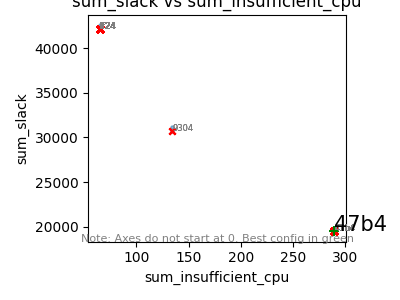

In [11]:
# display the plot
from IPython.display import Image
Image(filename='data_tuning/pareto_frontier.png')


Above you should see the pareto curve, saved to your tuning directory (ex: `data_tuning/pareto_frontier.png`).

### More analysis

The parameter combination that is the closest to (0,0) is marked with a green x and labeled with the last 4 digits of the uuid of the `target_cfg` folder.  You can read more details about this in the [paper](https://www.microsoft.com/en-us/research/publication/caasper-vertical-autoscaling/) in Figure 6.

In [12]:
# This function returns folder, config, dimension_1, and dimension_2 of the closest combination
# We don't know what folder will be because it's random, but we can check the other values
# We know that a config with the added value of 1 has the least slack and expect that to be the closest to zero
folder, config, slack, insuff_cpu = pareto_2d.find_closest_to_zero()

print(f"Folder: {folder}")
# for config, we have a nested dictionary, so we need to print it out
# now print all the configs
print("All Configs:")
print(f"algo_specific_config: {config.get('algo_specific_config')}")
print(f"general_config: {config.get('general_config')}")
print(f"predictive_config: {config.get('predictive_config')}")

print(f"Slack: {slack}")
print(f"Insufficient CPU: {insuff_cpu}")

Closest combination to (0, 0) is dimension_1: 19487.21896972081, dimension_2: 289.95169699353437
Folder: target_cfg-b23fc16c-47b4, Config: {}
Folder: target_cfg-b23fc16c-47b4
All Configs:
algo_specific_config: {'addend': 1}
general_config: {'window': 60, 'lag': 10, 'max_cpu_limit': 25, 'min_cpu_limit': 1, 'recovery_time': 15}
predictive_config: None
Slack: 19487.21896972081
Insufficient CPU: 289.95169699353437


Going back to the original combinations:

```python
algo_specific_params_to_tune = {
    "addend": [1, 2, 3],  # the addend is the number of minutes to add to the prediction
}
params_to_tune = {
    'window': [60, 120],  # the window size is the number of minutes to consider for the prediction
}
```

We see that the best parameter for `addend` is 1, which makes sense because it will have the lowest buffer and therefore the least slack. But you may take a different approach in your analsis depending on your goals. (Ex: some customers prefer larger buffer and would say that `3 producted better results.)

We also see that the smaller window (`60` seconds) produced a better result. This is because for our smoothing algorithm, 120 minutes is too much data to do this effectively, a smaller amount is better.  

Now you can play around with new parameters and see what results you get!  

#### Important:

Make sure you clean up your folder before rerunning the simulation, else you will get innacurate results or errors



In [13]:
! rm -rf data/_simulations
! rm -rf data_tuning